## Write the title and other important information here,
## Talk about the dataset and the collaborators

# add standard scaling/ variable selection/ fine tuning LogReg

dataset from here https://www.kaggle.com/lava18/google-play-store-apps

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

In [2]:
# Load google play csv file into pandas dataframe
gp_dat = pd.read_csv("googleplaystore.csv")
gp_dat.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## Data Preprocessing

Rylie

Dropping the columns ['App', 'Current Ver', 'Android Ver', 'Genres'] due to not being relevant to the task at hand

In [3]:
# Rylie's code
gp_dat = gp_dat.drop(['App', 'Current Ver', 'Android Ver', 'Genres'], axis=1)

In [4]:
# Kyle's code
gp_dat = gp_dat.dropna(subset = ['Content Rating','Type'])

Printing description of all categorical attributes

In [5]:
# description of every categorical attribute
# Rylie's code
df_ = gp_dat.select_dtypes(exclude=['int64', 'float64'])
for col in df_.columns:
    print(df_[col].unique()) # to print categories name only
    print(df_[col].value_counts()) # to print count of every category

['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FINANCE' 'FOOD_AND_DRINK' 'HEALTH_AND_FITNESS' 'HOUSE_AND_HOME'
 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'GAME' 'FAMILY' 'MEDICAL' 'SOCIAL'
 'SHOPPING' 'PHOTOGRAPHY' 'SPORTS' 'TRAVEL_AND_LOCAL' 'TOOLS'
 'PERSONALIZATION' 'PRODUCTIVITY' 'PARENTING' 'WEATHER' 'VIDEO_PLAYERS'
 'NEWS_AND_MAGAZINES' 'MAPS_AND_NAVIGATION']
FAMILY                 1971
GAME                   1144
TOOLS                   843
MEDICAL                 463
BUSINESS                460
PRODUCTIVITY            424
PERSONALIZATION         392
COMMUNICATION           387
SPORTS                  384
LIFESTYLE               382
FINANCE                 366
HEALTH_AND_FITNESS      341
PHOTOGRAPHY             335
SOCIAL                  295
NEWS_AND_MAGAZINES      283
SHOPPING                260
TRAVEL_AND_LOCAL        258
DATING                  234
BOOKS_AND_REFERENCE     231
VI

### Missing Values
Looking for null values and dropping those found in the columns ['Content Rating','Type']

In [6]:
gp_dat.isnull().sum()

Category             0
Rating            1473
Reviews              0
Size                 0
Installs             0
Type                 0
Price                0
Content Rating       0
Last Updated         0
dtype: int64

In [7]:
# create new variable (missing value indicator for Rating)
# Rylie's code
gp_dat['Rating_Miss_Ind']=np.select([gp_dat.Rating.isnull()],[1])
gp_dat.Rating_Miss_Ind.value_counts()

0    9366
1    1473
Name: Rating_Miss_Ind, dtype: int64

replacing the missing values with the median because the attribute "Rating" is left skewed

In [8]:
# Replace NaN values for Rating with the mean of Rating
# Kyle's code (changed to median insteaed of mean)
gp_dat['Rating'] = gp_dat['Rating'].fillna(gp_dat['Rating'].median())

In [9]:
# Kyle's code
gp_dat['Reviews'] = gp_dat['Reviews'].astype('int64')

## Attribute tansformations
Rylie

Must change most of the attributes so they can be used in a machine learning algorithm

### "Type"

In [10]:
# changing TYPE to 0 if free and 1 if paid
# Rylie's code
gp_dat['Type'] = gp_dat['Type'].replace({'Free': 0, 'Paid': 1}, regex=True).astype(float)


### "Price"

In [11]:
# changing currency to integer in PRICE
gp_dat['Price'] = gp_dat['Price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

### "Size"

Here I had to create a kilobyte indicator column so I could remove the letters and transform each instance into integers and then divide all of the instances of Price that had the kilobyte indicator by 1000 so that all of the sizes are in Megabytes

In [12]:
# setting indicator for Kilobytes
gp_dat['Size_K']=np.select([gp_dat.Size.str.contains('k')],[1])

In [13]:
gp_dat['Size_K'].value_counts()

0    10523
1      316
Name: Size_K, dtype: int64

In [14]:
# set 'Varies with device' as NA then replace with mean after conversion for SIZE in Megabytes
gp_dat['Size'] = gp_dat['Size'].replace({'Varies with device': np.NaN, 'M' : '', 'k': ''}, regex=True).astype(float)

In [15]:
# Varies with device value indicator for SIZE
gp_dat['Size_Varies_Ind']=np.select([gp_dat.Size.isnull()],[1])
gp_dat.Size_Varies_Ind.value_counts()

0    9145
1    1694
Name: Size_Varies_Ind, dtype: int64

In [16]:
# converting all Kilobyte instances to Megaabytes
gp_dat.loc[gp_dat['Size_K'] == 1, 'Size'] = gp_dat['Size']/1000

In [17]:
# Replacing all "Varies with Device" with mean in Megaabytes
gp_dat['Size'] = gp_dat['Size'].fillna(gp_dat['Size'].mean())

In [18]:
# dropping kilobyte indicator
gp_dat = gp_dat.drop(['Size_K'], axis=1)

In [19]:
gp_dat.Size.describe()

count    10839.000000
mean        21.516530
std         20.748452
min          0.008500
25%          5.900000
50%         18.000000
75%         26.000000
max        100.000000
Name: Size, dtype: float64

In [20]:
gp_dat.isnull().sum()

Category           0
Rating             0
Reviews            0
Size               0
Installs           0
Type               0
Price              0
Content Rating     0
Last Updated       0
Rating_Miss_Ind    0
Size_Varies_Ind    0
dtype: int64

### "Installs"

In [21]:
gp_dat['Installs'] = gp_dat['Installs'].map(lambda x: x.rstrip('+-'))

In [22]:
gp_dat['Installs'] = gp_dat['Installs'].replace({',': ''}, regex=True).astype(float)

### "Last Updated"
changing it to just the year the app was updated so we can categorize them by year

In [23]:
# changing last updated to just the year for grouping
gp_dat['Last Updated'] = gp_dat['Last Updated'].apply(lambda x: x[-4:])


In [24]:
gp_dat['Last Updated'] = gp_dat['Last Updated'].astype(float)

## Dummy Encoding
Rylie

In [25]:
# generate binary values using get_dummies
gp_dat = pd.get_dummies(gp_dat, columns=["Category","Last Updated", "Content Rating"])

In [26]:
gp_dat.head()

,Rating,Reviews,Size,Installs,Type,Price,Rating_Miss_Ind,Size_Varies_Ind,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,...,Last Updated_2015.0,Last Updated_2016.0,Last Updated_2017.0,Last Updated_2018.0,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated
0,4.1,159,19.0,10000.0,0.0,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
1,3.9,967,14.0,500000.0,0.0,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
2,4.7,87510,8.7,5000000.0,0.0,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
3,4.5,215644,25.0,50000000.0,0.0,0.0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
4,4.3,967,2.8,100000.0,0.0,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0


In [27]:
gp_dat['Type'].value_counts()

0.0    10039
1.0      800
Name: Type, dtype: int64

Drop the Price variable because it is positively coorelated with the target variable. The target variable is actually derived from the Price variable.

In [28]:
gp_dat = gp_dat.drop(['Price'], axis=1)

## Random Sampling/ Known Sampling

take a random subset of the free apps so that the classes of the target variable are equal and not skewed. Skewed classes in the target variable do not perform well in machine learning algorithms/ started with random sampling and then decided to go with a known sampling and settled on using the first 800 observations of the FREE class in the target variable and produced models that performed extremely well.

In [29]:
gp_dat_paid = gp_dat[gp_dat['Type'] == 1]
gp_dat_free = gp_dat[gp_dat['Type'] == 0]

In [30]:
gp_dat_paid.shape

(800, 55)

In [31]:
gp_dat_free.shape

(10039, 55)

In [32]:
#gp_dat_free_f = gp_dat_free.sample(800, random_state=5)
gp_dat_free_f = gp_dat_free[:800]
gp_dat_free_f.shape

(800, 55)

In [33]:
gp_dat2 = pd.concat([gp_dat_paid, gp_dat_free_f])

Showing the counts of the classes in the target variable

In [34]:
# y includes our labels and x includes our features
dlist = ['Type']
x1 = gp_dat.drop(dlist, axis=1)
y1 = gp_dat['Type']

In [35]:
#actual learning data set where equal target values
dlist = ['Type']
x = gp_dat2.drop(dlist, axis=1)
y = gp_dat2['Type']

Number of Paid:  800
Number of Free:  10039


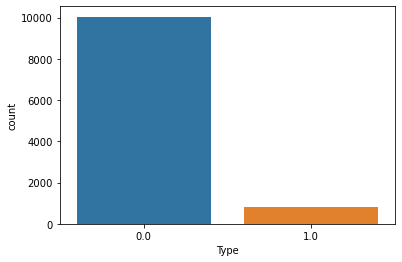

In [36]:
# class break down of the target attribute in the full dataset
ax = sns.countplot(y1,label="Count")       
F, P = y1.value_counts()                   # 0 if Free 1 if paid
print('Number of Paid: ',P)
print('Number of Free: ',F)

Number of Paid:  800
Number of Free:  800


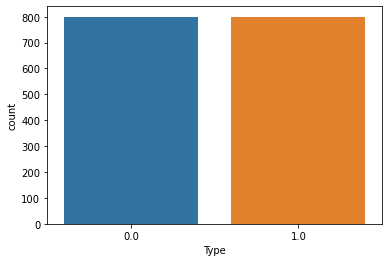

In [37]:
# class break down of the target attribute in the subset used for the predictions
ax = sns.countplot(y,label="Count")       
F, P = y.value_counts()                   # 0 if Free 1 if paid
print('Number of Paid: ',P)
print('Number of Free: ',F)

## Predicting the Type

Using random sample of 800 from the free dataset so that our target variables are not skewed

Rylie

In [38]:
#split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

[0.8791666666666667, 0.8291666666666667, 0.8625, 0.8604166666666667, 0.8625, 0.8583333333333333, 0.8708333333333333, 0.86875, 0.8708333333333333]


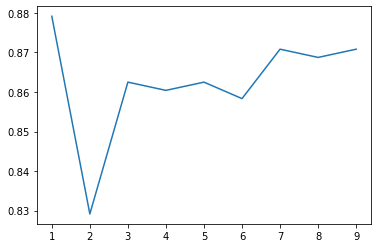

In [39]:
# hyperparameter tuning of K Nearest Neighbors Classifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

scores = []

for neighbors in range(1,10):
    clf_nn = KNeighborsClassifier(n_neighbors=neighbors, metric='minkowski')
    
    clf_nn.fit(x_train, y_train)
    y_pred = clf_nn.predict(x_test)
    scores.append(accuracy_score(y_test,y_pred))
print(scores)    
plt.plot(list(range(1,10)), scores)
plt.show()

Train accuracy is:  1.0
Test accuracy is:  0.8791666666666667
Precision score is:  0.8847736625514403
Recall score is:  0.8775510204081632


<AxesSubplot:>

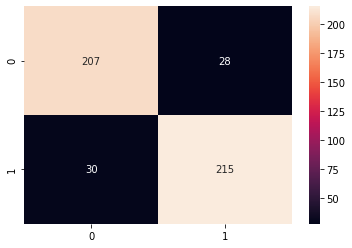

In [40]:
# KNN classifier
clf_nn = KNeighborsClassifier(n_neighbors=1, metric='minkowski')
    
clf_nn.fit(x_train, y_train)
y_pred = clf_nn.predict(x_test)


actrain = accuracy_score(y_train,clf_nn.predict(x_train))
print('Train accuracy is: ',actrain)
ac = accuracy_score(y_test,clf_nn.predict(x_test))
print('Test accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_nn.predict(x_test))

prec = precision_score(y_test,clf_nn.predict(x_test))
print('Precision score is: ',prec)

rec = recall_score(y_test,clf_nn.predict(x_test))
print('Recall score is: ',rec)

sns.heatmap(cm,annot=True,fmt="d")


Train accuracy is:  0.8276785714285714
Test accuracy is:  0.8104166666666667
Precision score is:  0.75
Recall score is:  0.9428571428571428


<AxesSubplot:>

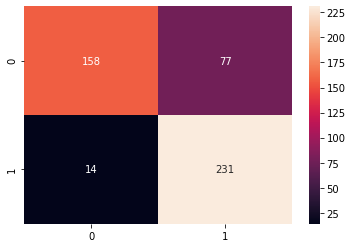

In [41]:
# Logistic Regression Classifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score


clf_lr = LogisticRegression(C=1e5, solver='lbfgs')
    
clf_lr.fit(x_train, y_train)
y_pred = clf_lr.predict(x_test)

actrain = accuracy_score(y_train,clf_lr.predict(x_train))
print('Train accuracy is: ',actrain)
    
ac = accuracy_score(y_test,clf_lr.predict(x_test))
print('Test accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_lr.predict(x_test))

prec = precision_score(y_test,clf_lr.predict(x_test))
print('Precision score is: ',prec)

rec = recall_score(y_test,clf_lr.predict(x_test))
print('Recall score is: ',rec)

sns.heatmap(cm,annot=True,fmt="d")

[0.7708333333333334, 0.83125, 0.8541666666666666, 0.8854166666666666, 0.8854166666666666, 0.8916666666666667, 0.9083333333333333, 0.9145833333333333, 0.9166666666666666, 0.9270833333333334, 0.9270833333333334, 0.9270833333333334, 0.9375, 0.9375, 0.9604166666666667, 0.9645833333333333, 0.9645833333333333, 0.9645833333333333, 0.9645833333333333, 0.9645833333333333, 0.9645833333333333, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.96875, 0.96875, 0.96875, 0.96875]


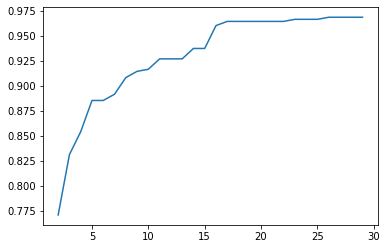

In [42]:
# hyperparameter tuning of Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

scores = []

for leaves in range(2,30):
    clf_dt = DecisionTreeClassifier(max_leaf_nodes=leaves, random_state=0,
                                   criterion='entropy')
    clf_dt.fit(x_train,y_train)
    y_pred = clf_dt.predict(x_test)
    
    scores.append(accuracy_score(y_test,y_pred))
print(scores)
plt.plot(list(range(2,30)), scores)
plt.show()

Train accuracy is:  0.9928571428571429
Test accuracy is:  0.96875
Precision score is:  0.9752066115702479
Recall score is:  0.963265306122449


<AxesSubplot:>

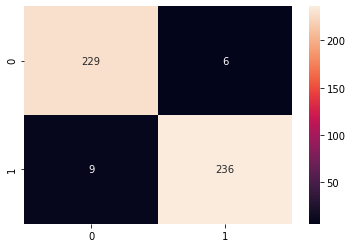

In [43]:
# Decision Tree Classifier
clf_dt = DecisionTreeClassifier(max_leaf_nodes=30, random_state=0,
                                   criterion='entropy')
clf_dt.fit(x_train,y_train)
y_pred = clf_dt.predict(x_test)

actrain = accuracy_score(y_train,clf_dt.predict(x_train))
print('Train accuracy is: ',actrain)
    
ac = accuracy_score(y_test,clf_dt.predict(x_test))
print('Test accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_dt.predict(x_test))

prec = precision_score(y_test,clf_dt.predict(x_test))
print('Precision score is: ',prec)

rec = recall_score(y_test,clf_dt.predict(x_test))
print('Recall score is: ',rec)

sns.heatmap(cm,annot=True,fmt="d")



[0.8458333333333333, 0.875, 0.875, 0.8958333333333334, 0.9166666666666666, 0.925, 0.9395833333333333, 0.9458333333333333, 0.9520833333333333, 0.95625, 0.95625, 0.9645833333333333, 0.9604166666666667, 0.9625, 0.96875, 0.9708333333333333, 0.9708333333333333, 0.96875, 0.9708333333333333, 0.9708333333333333, 0.96875, 0.96875, 0.9708333333333333, 0.96875, 0.96875, 0.96875, 0.96875, 0.96875]


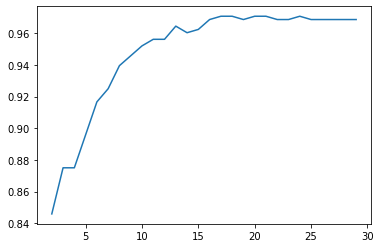

In [44]:
from sklearn.ensemble import RandomForestClassifier

scores = []

for depth in range(2,30):
    clf_rf = RandomForestClassifier(max_depth=depth, n_estimators=100, random_state=3,
                                   criterion='entropy')
    clf_rf.fit(x_train,y_train)
    y_pred = clf_rf.predict(x_test)
    
    scores.append(accuracy_score(y_test,y_pred))
print(scores)
plt.plot(list(range(2,30)), scores)
plt.show()


Train accuracy is:  1.0
Test accuracy is:  0.9708333333333333
Precision score is:  0.9753086419753086
Recall score is:  0.9673469387755103


<AxesSubplot:>

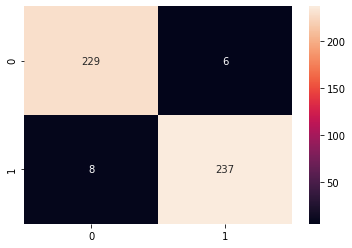

In [45]:
clf_rf = RandomForestClassifier(max_depth=24, n_estimators=100, random_state=3,
                                   criterion='entropy')
clf_rf.fit(x_train,y_train)
y_pred = clf_rf.predict(x_test)

actrain = accuracy_score(y_train,clf_rf.predict(x_train))
print('Train accuracy is: ',actrain)
    
ac = accuracy_score(y_test,clf_rf.predict(x_test))
print('Test accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(x_test))

prec = precision_score(y_test,clf_rf.predict(x_test))
print('Precision score is: ',prec)

rec = recall_score(y_test,clf_rf.predict(x_test))
print('Recall score is: ',rec)

sns.heatmap(cm,annot=True,fmt="d")


In [46]:
#import graphviz

#dot_data = tree.export_graphviz(clf_rf[0], out_file=None) 
#graph = graphviz.Source(dot_data) 
#graph.render("googleplay")